# AR(1)参数的后验分布

我们先从导入一些Python包开始。

In [1]:
!pip install arviz pymc numpyro jax

  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 \

 done


  Preparing metadata (setup.py) ... -

 \ done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 132.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.4 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 179.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/105.1 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 46.1/105.1 MB 233.3 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 79.7/105.1 MB 199.3 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 105.1/105.1 MB 210.3 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 153.6 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 202.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 139.3 MB/s eta 0:00:00


 \

 |

 done
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9094 sha256=daef3b801a7bbd5beb1763dc463465efe90799a1da43826f803fe106f7982d22
  Stored in directory: /home/runner/.cache/pip/wheels/91/0c/f7/7ba4ffbf0db6bf272bee59789131f6ec2d26966307a3054267


 \

 done
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13912 sha256=47bdcbace5cd908edfae47caf81e184326ac7fdc4382603d9c7fe023507dea60
  Stored in directory: /home/runner/.cache/pip/wheels/4b/07/cf/3fdaedafc40d7b1861c98be0df1bf3b2b3e87e03187fa95298


 \

 done
  Created wheel for etuples: filename=etuples-0.3.9-py3-none-any.whl size=12619 sha256=46921e5bf06f9a70f2744cc17ad85e113fa2e97480274939be61511a2dd65b70
  Stored in directory: /home/runner/.cache/pip/wheels/9e/ea/42/9562f37ce4e92913b74da9bcd504a749f0bf5d42d1d148ca76


 \

 | done
  Created wheel for miniKanren: filename=miniKanren-1.0.3-py3-none-any.whl size=23908 sha256=646f8736ce8329d6baf54830e2cd1906cf26b3e687ad27d63bd24b98112a4bf9
  Stored in directory: /home/runner/.cache/pip/wheels/57/48/e3/441a42666f9a4ac9ccb6897d6046d81cf970c986be39938c6e
Successfully built cons logical-unification etuples miniKanren


  Attempting uninstall: filelock
    Found existing installation: filelock 3.13.1
    Uninstalling filelock-3.13.1:
      Successfully uninstalled filelock-3.13.1


In [2]:
import arviz as az
import pymc as pmc
import numpyro
from numpyro import distributions as dist

import numpy as np
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']


import logging
logging.basicConfig()
logger = logging.getLogger('pymc')
logger.setLevel(logging.CRITICAL)


本讲座使用[pymc](https://www.pymc.io/projects/docs/en/stable/)和[numpyro](https://num.pyro.ai/en/stable/)提供的贝叶斯方法对一元一阶自回归的两个参数进行统计推断。

该模型是一个很好的实验室，用于说明对初始值$y_0$分布建模的不同方式所带来的影响：

- 作为一个固定数值

- 作为从$\{y_t\}$随机过程的平稳分布中抽取的随机变量

统计模型的第一个组成部分是

$$
y_{t+1} = \rho y_t + \sigma_x \epsilon_{t+1}, \quad t \geq 0
$$ (eq:themodel)

其中标量$\rho$和$\sigma_x$满足$|\rho| < 1$和$\sigma_x > 0$；
$\{\epsilon_{t+1}\}$是一个均值为$0$、方差为$1$的独立同分布正态随机变量序列。

统计模型的第二个组成部分是

$$
y_0 \sim {\cal N}(\mu_0, \sigma_0^2)
$$ (eq:themodel_2)

考虑由该统计模型生成的样本$\{y_t\}_{t=0}^T$。
该模型表明 $\{y_t\}_{t=0}^T$ 的似然函数可以被**分解**为：

$$
f(y_T, y_{T-1}, \ldots, y_0) = f(y_T| y_{T-1}) f(y_{T-1}| y_{T-2}) \cdots f(y_1 | y_0 ) f(y_0)
$$

这里我们用 $f$ 表示一般的概率密度。

统计模型 {eq}`eq:themodel`-{eq}`eq:themodel_2` 表明

$$
\begin{aligned}
f(y_t | y_{t-1})  & \sim {\mathcal N}(\rho y_{t-1}, \sigma_x^2) \\
        f(y_0)  & \sim {\mathcal N}(\mu_0, \sigma_0^2)
\end{aligned}
$$

我们想研究关于未知参数 $(\rho, \sigma_x)$ 的推断如何依赖于对 $y_0$ 分布的参数 $\mu_0, \sigma_0$ 的假设。

下面，我们研究两种广泛使用的替代假设：

- $(\mu_0,\sigma_0) = (y_0, 0)$ 意味着 $y_0$ 是从分布 ${\mathcal N}(y_0, 0)$ 中抽取的；实际上，我们是在**基于观察到的初始值进行条件化**。
-  $\mu_0,\sigma_0$ 是 $\rho, \sigma_x$ 的函数，因为 $y_0$ 是从由 $\rho, \sigma_x$ 决定的平稳分布中抽取的。

**注意：** 我们**不**考虑第三种可能的情况，即将 $\mu_0,\sigma_0$ 作为需要估计的自由参数。

未知参数是 $\rho, \sigma_x$。

我们有 $\rho, \sigma_x$ 的独立**先验概率分布**，并希望在观察到样本 $\{y_{t}\}_{t=0}^T$ 后计算后验概率分布。

这个笔记本使用 `pymc4` 和 `numpyro` 来计算 $\rho, \sigma_x$ 的后验分布。我们将使用 NUTS 采样器在链中生成后验分布的样本。这两个库都支持 NUTS 采样器。
NUTS是一种蒙特卡洛马尔可夫链（MCMC）算法，它避免了随机游走行为，能更快地收敛到目标分布。这不仅具有速度上的优势，还允许在不需要掌握那些拟合方法背后专门理论知识的情况下，拟合复杂模型。

因此，我们探讨对$y_0$分布做出这些替代假设的后果：

- 第一种方法是以观察到的$y_0$值为条件。这相当于假设随机变量$y_0$的概率分布是一个狄拉克德尔塔函数，它在观察到的$y_0$值上的概率为1。

- 第二种方法假设$y_0$是从{eq}`eq:themodel`所描述过程的平稳分布中抽取的，
因此$y_0 \sim {\cal N} \left(0, {\sigma_x^2\over (1-\rho)^2} \right)$
当初始值$y_0$位于平稳分布尾部较远处时，对初始值进行条件化会得到一个**更准确的**后验分布，我们将对此进行解释。

基本上，当$y_0$恰好位于平稳分布的尾部，而我们**不对$y_0$进行条件化**时，$\{y_t\}_{t=0}^T$的似然函数会调整参数对$\rho, \sigma_x$的后验分布，使得观测到的$y_0$值在平稳分布下比实际情况更可能出现，从而在短样本中对后验分布产生不利的扭曲。

下面的例子展示了不对$y_0$进行条件化是如何不利地将$\rho$的后验概率分布向更大的值偏移的。

我们首先通过求解一个**直接问题**来模拟AR(1)过程。

我们如何选择初始值$y_0$是很重要的。
* 如果我们认为 $y_0$ 是从平稳分布 ${\mathcal N}(0, \frac{\sigma_x^{2}}{1-\rho^2})$ 中抽取的，那么使用这个分布作为 $f(y_0)$ 是个好主意。为什么？因为 $y_0$ 包含了关于 $\rho, \sigma_x$ 的信息。

* 如果我们怀疑 $y_0$ 位于平稳分布的尾部很远的位置——以至于样本中早期观测值的变化具有显著的**瞬态成分**——最好通过设置 $f(y_0) = 1$ 来对 $y_0$ 进行条件化。

为了说明这个问题，我们将从选择一个位于平稳分布尾部很远的初始值 $y_0$ 开始。

In [3]:
def ar1_simulate(rho, sigma, y0, T):

    # Allocate space and draw epsilons
    y = np.empty(T)
    eps = np.random.normal(0.,sigma,T)

    # Initial condition and step forward
    y[0] = y0
    for t in range(1, T):
        y[t] = rho*y[t-1] + eps[t]

    return y

sigma =  1.
rho = 0.5
T = 50

np.random.seed(145353452)
y = ar1_simulate(rho, sigma, 10, T)

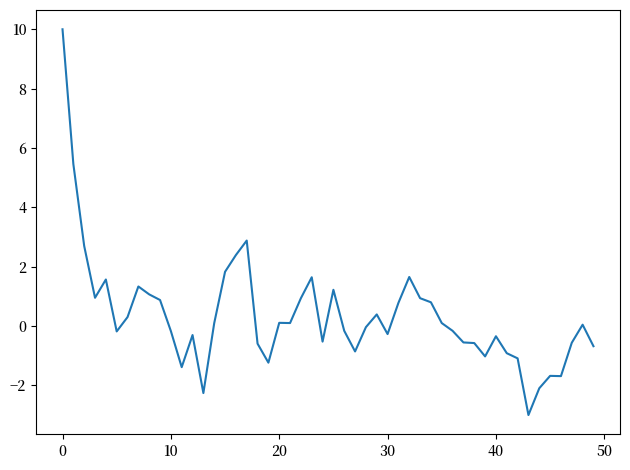

In [4]:
plt.plot(y)
plt.tight_layout()

现在我们将使用贝叶斯定理来构建后验分布，以初始值$y_0$为条件。

(稍后我们会假设$y_0$是从平稳分布中抽取的，但现在不作此假设。)

首先我们将使用**pymc4**。

## PyMC实现

对于`pymc`中的正态分布，
$var = 1/\tau = \sigma^{2}$。

In [5]:
AR1_model = pmc.Model()

with AR1_model:

    # 首先设定先验分布
    rho = pmc.Uniform('rho', lower=-1., upper=1.) # 假设rho是稳定的
    sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

    # 下一期y的期望值(rho * y)
    yhat = rho * y[:-1]

    # 实际值的似然函数
    y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=y[1:])

[pmc.sample](https://www.pymc.io/projects/docs/en/v5.10.0/api/generated/pymc.sample.html#pymc-sample) 默认使用NUTS采样器来生成样本，如下面的代码单元所示：

In [6]:
with AR1_model:
    trace = pmc.sample(50000, tune=10000, return_inferencedata=True)

Output()

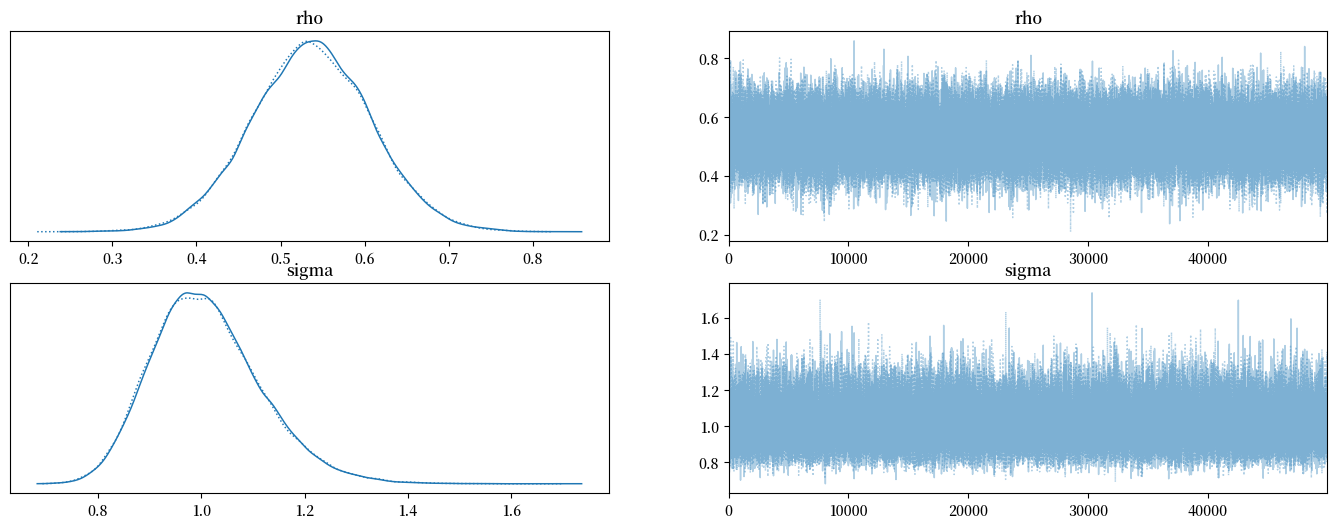

In [7]:
with AR1_model:
    az.plot_trace(trace, figsize=(17,6))

显然，后验分布并没有以我们用来生成数据的真实值 $.5, 1$ 为中心。

这是一阶自回归过程中经典的**赫维奇偏差**（Hurwicz bias）的表现（参见 Leonid Hurwicz {cite}`hurwicz1950least`）。

赫维奇偏差在样本量越小时表现得越明显（参见 {cite}`Orcutt_Winokur_69`）。

不管怎样，这里是关于后验分布的更多信息。

In [8]:
with AR1_model:
    summary = az.summary(trace, round_to=4)

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.5364,0.0708,0.4037,0.6703,0.0002,0.0002,86208.3046,62589.1511,1.0001
sigma,1.0105,0.1064,0.8163,1.2087,0.0004,0.0004,84055.3687,65155.7083,1.0001


现在我们将计算在观察到相同数据但假设 $y_0$ 是从平稳分布中抽取的情况下的后验分布。

这意味着

$$
y_0 \sim N \left(0, \frac{\sigma_x^{2}}{1 - \rho^{2}} \right)
$$

我们按如下方式修改代码：

In [9]:
AR1_model_y0 = pmc.Model()

with AR1_model_y0:

    # 首先设定先验分布
    rho = pmc.Uniform('rho', lower=-1., upper=1.) # 假设 rho 是稳定的
    sigma = pmc.HalfNormal('sigma', sigma=np.sqrt(10))

    # 平稳 y 的标准差
    y_sd = sigma / np.sqrt(1 - rho**2)

    # yhat
    yhat = rho * y[:-1]
    y_data = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=y[1:])
    y0_data = pmc.Normal('y0_obs', mu=0., sigma=y_sd, observed=y[0])

In [10]:
with AR1_model_y0:
    trace_y0 = pmc.sample(50000, tune=10000, return_inferencedata=True)

# 灰色垂直线表示发散的情况

Output()

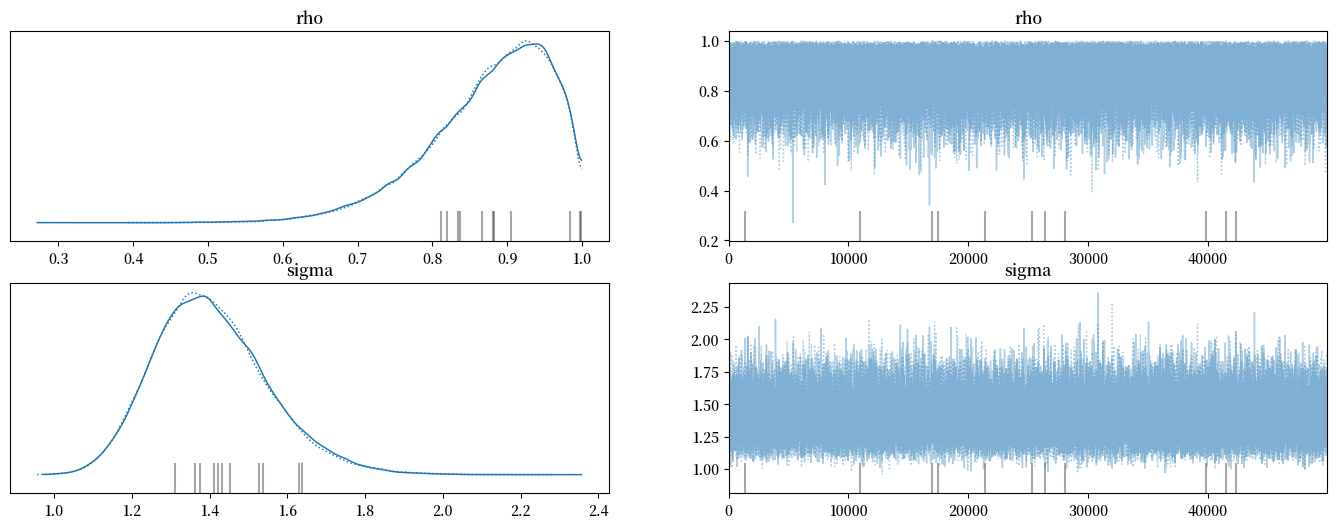

In [11]:
with AR1_model_y0:
    az.plot_trace(trace_y0, figsize=(17,6))

In [12]:
with AR1_model:
    summary_y0 = az.summary(trace_y0, round_to=4)

summary_y0

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.8756,0.0811,0.7314,0.9983,0.0003,0.0003,56392.5794,41991.4684,1.0
sigma,1.4041,0.1466,1.1350,1.6785,0.0006,0.0005,68636.8084,55935.7336,1.0


请注意当我们基于$y_0$进行条件化而不是假设$y_0$来自平稳分布时，$\rho$的后验分布相对向右偏移。

思考一下为什么会发生这种情况。

```{hint}
这与贝叶斯定律(条件概率)如何通过对使观测值更可能出现的参数值赋予高概率来解决**逆问题**有关。
```

在我们使用`numpyro`来计算这两种关于$y_0$分布的假设下的后验分布之前,我们会回到这个问题。

我们现在用`numpyro`重复这些计算。

## Numpyro实现

In [13]:

def plot_posterior(sample):
    """
    绘制轨迹和直方图
    """
    # 转换为np数组
    rhos = sample['rho']
    sigmas = sample['sigma']
    rhos, sigmas, = np.array(rhos), np.array(sigmas)

    fig, axs = plt.subplots(2, 2, figsize=(17, 6))
    # 绘制轨迹
    axs[0, 0].plot(rhos)   # rho
    axs[1, 0].plot(sigmas) # sigma

    # 绘制后验分布
    axs[0, 1].hist(rhos, bins=50, density=True, alpha=0.7)
    axs[0, 1].set_xlim([0, 1])
    axs[1, 1].hist(sigmas, bins=50, density=True, alpha=0.7)

    axs[0, 0].set_title("rho")
    axs[0, 1].set_title("rho")
    axs[1, 0].set_title("sigma")
    axs[1, 1].set_title("sigma")
    plt.show()

In [14]:
def AR1_model(data):
    # 设置先验分布
    rho = numpyro.sample('rho', dist.Uniform(low=-1., high=1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=np.sqrt(10)))

    # 下一期y的期望值 (rho * y)
    yhat = rho * data[:-1]

    # 实际值的似然函数
    y_data = numpyro.sample('y_obs', dist.Normal(loc=yhat, scale=sigma), obs=data[1:])


In [15]:
# 创建 jnp 数组
y = jnp.array(y)

# 设置 NUTS 核心
NUTS_kernel = numpyro.infer.NUTS(AR1_model)

# 运行 MCMC
mcmc = numpyro.infer.MCMC(NUTS_kernel, num_samples=50000, num_warmup=10000, progress_bar=False)
mcmc.run(rng_key=random.PRNGKey(1), data=y)

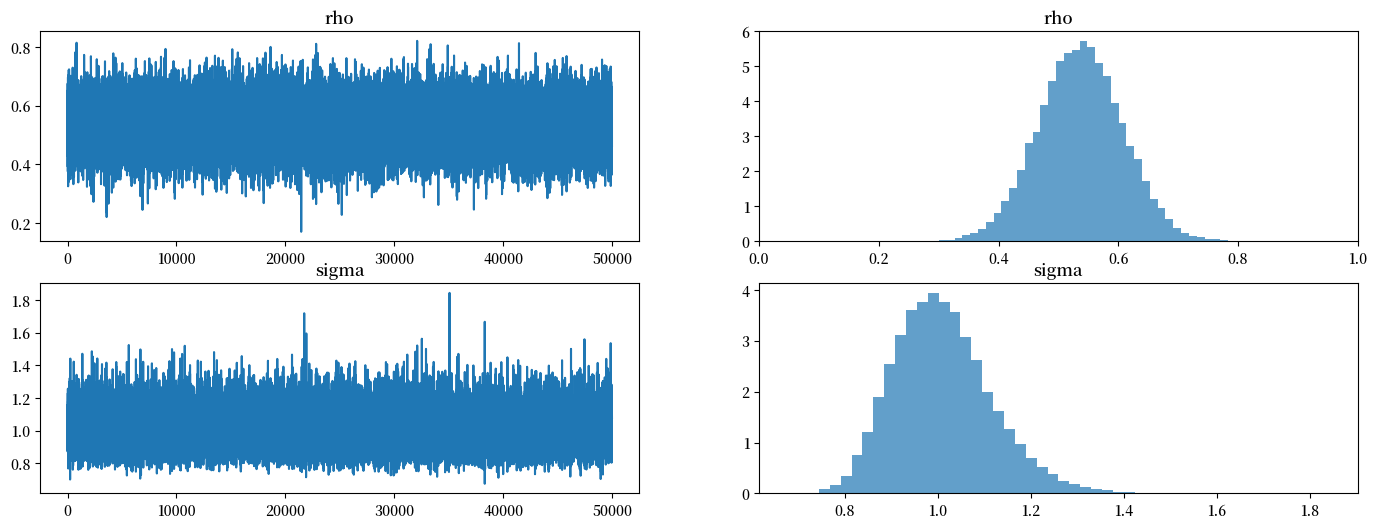

In [16]:
plot_posterior(mcmc.get_samples())

In [17]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       rho      0.54      0.07      0.54      0.42      0.66  32559.69      1.00
     sigma      1.01      0.11      1.00      0.84      1.18  32131.88      1.00

Number of divergences: 0


接下来，我们再次计算后验分布，这次假设 $y_0$ 是从平稳分布中抽取的，因此

$$
y_0 \sim N \left(0, \frac{\sigma_x^{2}}{1 - \rho^{2}} \right)
$$

以下是实现这一目的的新代码。

In [18]:
def AR1_model_y0(data):
    # 设置先验分布
    rho = numpyro.sample('rho', dist.Uniform(low=-1., high=1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=np.sqrt(10)))

    # 平稳y的标准差
    y_sd = sigma / jnp.sqrt(1 - rho**2)

    # 下一期y的期望值(rho * y)
    yhat = rho * data[:-1]

    # 实际实现值的似然
    y_data = numpyro.sample('y_obs', dist.Normal(loc=yhat, scale=sigma), obs=data[1:])
    y0_data = numpyro.sample('y0_obs', dist.Normal(loc=0., scale=y_sd), obs=data[0])

In [19]:
# 创建jnp数组
y = jnp.array(y)

# 设置NUTS核心
NUTS_kernel = numpyro.infer.NUTS(AR1_model_y0)

# 运行MCMC
mcmc2 = numpyro.infer.MCMC(NUTS_kernel, num_samples=50000, num_warmup=10000, progress_bar=False)
mcmc2.run(rng_key=random.PRNGKey(1), data=y)

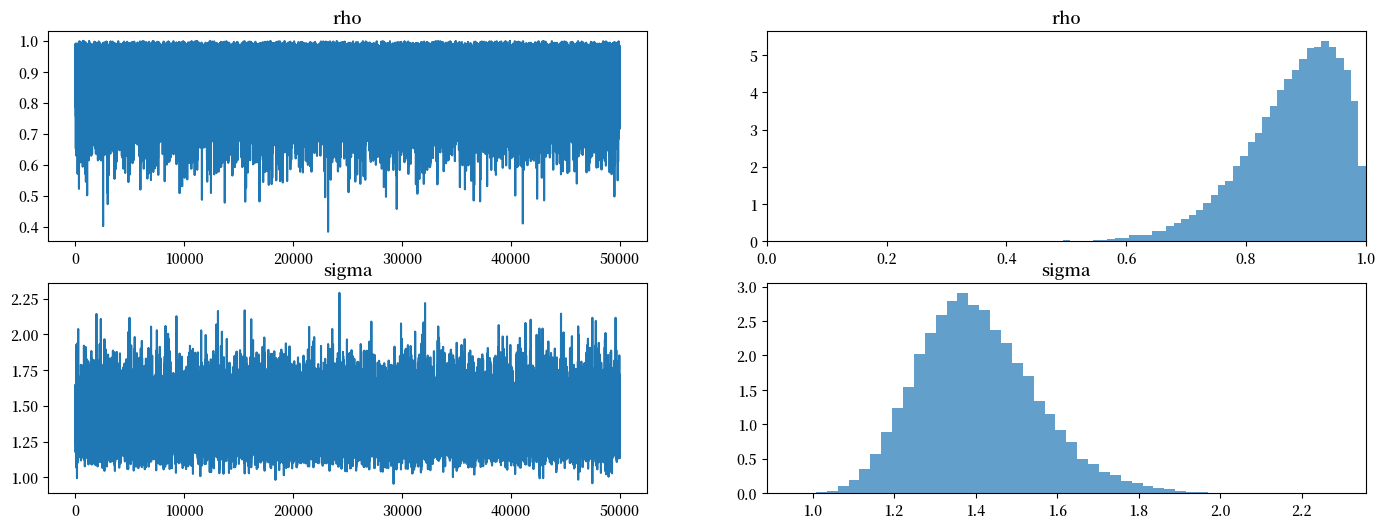

In [20]:
plot_posterior(mcmc2.get_samples())

In [21]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       rho      0.88      0.08      0.89      0.76      1.00  31896.52      1.00
     sigma      1.41      0.15      1.39      1.17      1.63  32211.95      1.00

Number of divergences: 0


看看后验分布发生了什么！

由于贝叶斯定律（即条件概率）告诉`numpyro`要解释样本早期它认为是"爆炸性"的观测值，后验分布已经远离了用于生成数据的参数真实值。

贝叶斯定律通过驱使$\rho \rightarrow 1$和$\sigma \uparrow$来提高平稳分布的方差，从而能够为第一个观测值生成一个合理的似然。

我们的例子说明了你对初始条件分布的假设有多么重要。